In [1]:
import os
import requests
import zipfile
import tarfile
import hashlib

In [2]:
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [9]:
def download(name, cache_dir = os.path.join('.', 'data')):   #@save
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    d2l.mkdir_if_not_exist(cache_dir)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
        
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [10]:
def download_extract(name, folder=None): #@save
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [11]:
def download_all(): #@save
    for name in DATA_HUB:
        download(name)

In [12]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

In [13]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [14]:
train_data = pd.read_csv(download('kaggle_house_train'))

In [16]:
test_data = pd.read_csv(download('kaggle_house_test'))

In [17]:
print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


In [18]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [20]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)

(2919, 79)


In [24]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
print(numeric_features)
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x : (x - x.mean()) / x.std()
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [25]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [26]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [62]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
dropout1, dropout2 = 0.2, 0.5

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [52]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(torch.mean(loss(torch.log(clipped_preds), torch.log(labels))))
    return rmse.item()

In [54]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay = weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [49]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [56]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1},  train log rmse {float(train_ls[-1]):f}, valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1,  train log rmse 5.093337, valid log rmse 5.179841
fold 2,  train log rmse 2.432899, valid log rmse 2.409138
fold 3,  train log rmse 3.358003, valid log rmse 3.316940
fold 4,  train log rmse 5.105650, valid log rmse 5.059515
fold 5,  train log rmse 2.370986, valid log rmse 2.930473
5-fold validation: avg train log rmse: 3.672175, avg valid log rmse: 3.779181


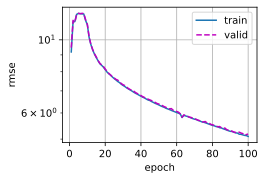

In [63]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')

In [58]:
def train_and_pred(train_features, test_Feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse', yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = d2l.numpy(net(test_features))
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162201


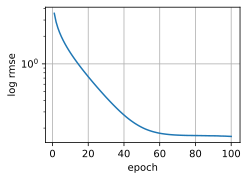

In [59]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

fold 1,  train log rmse 0.065567, valid log rmse 0.131997
fold 2,  train log rmse 0.049515, valid log rmse 0.162126
fold 3,  train log rmse 0.035586, valid log rmse 0.151063
fold 4,  train log rmse 0.038864, valid log rmse 0.640315
fold 5,  train log rmse 0.056042, valid log rmse 0.150318
5-fold validation: avg train log rmse: 0.049115, avg valid log rmse: 0.247164
train log rmse 0.306666


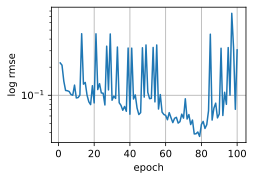

In [68]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Linear(256, 1))
    return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

fold 1,  train log rmse 0.048804, valid log rmse 0.156963
fold 2,  train log rmse 0.034919, valid log rmse 0.171765
fold 3,  train log rmse 0.043115, valid log rmse 0.164752
fold 4,  train log rmse 0.039210, valid log rmse 0.141136
fold 5,  train log rmse 0.035731, valid log rmse 0.177730
5-fold validation: avg train log rmse: 0.040356, avg valid log rmse: 0.162469


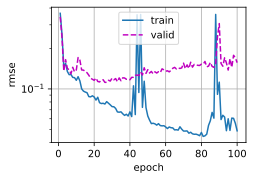

In [65]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Linear(256, 1))
    return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')

fold 1,  train log rmse 0.042217, valid log rmse 0.674384
fold 2,  train log rmse 0.105316, valid log rmse 0.720016
fold 3,  train log rmse 0.045694, valid log rmse 0.182064
fold 4,  train log rmse 0.031902, valid log rmse 0.122281
fold 5,  train log rmse 0.056584, valid log rmse 0.146383
5-fold validation: avg train log rmse: 0.056343, avg valid log rmse: 0.369026


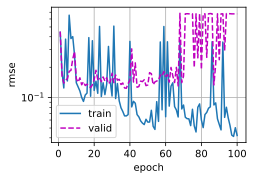

In [66]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Linear(256, 1))
    return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0.1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')

fold 1,  train log rmse 0.097943, valid log rmse 0.157520
fold 2,  train log rmse 0.048800, valid log rmse 0.193431
fold 3,  train log rmse 0.075815, valid log rmse 0.165392
fold 4,  train log rmse 0.043447, valid log rmse 0.125701
fold 5,  train log rmse 0.042678, valid log rmse 0.182089
5-fold validation: avg train log rmse: 0.061737, avg valid log rmse: 0.164827


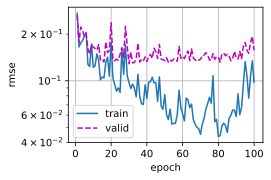

In [67]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 128), nn.ReLU(), nn.Linear(128, 1))
    return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0.1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')

fold 1,  train log rmse 0.100917, valid log rmse 0.180923
fold 2,  train log rmse 0.067082, valid log rmse 0.169373
fold 3,  train log rmse 0.060493, valid log rmse 0.164029
fold 4,  train log rmse 0.075049, valid log rmse 0.145862
fold 5,  train log rmse 0.063657, valid log rmse 0.181621
5-fold validation: avg train log rmse: 0.073440, avg valid log rmse: 0.168362


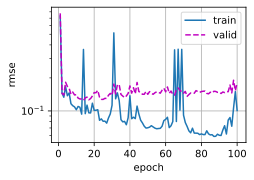

In [71]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Linear(256, 1))
    return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')

fold 1,  train log rmse 0.875729, valid log rmse 0.886043
fold 2,  train log rmse 0.875350, valid log rmse 0.888373
fold 3,  train log rmse 0.874265, valid log rmse 0.889577
fold 4,  train log rmse 0.881626, valid log rmse 0.856648
fold 5,  train log rmse 0.876628, valid log rmse 0.880654
5-fold validation: avg train log rmse: 0.876720, avg valid log rmse: 0.880259


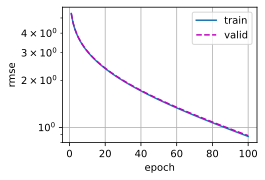

In [75]:
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0.5, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')